In [1]:
%load_ext autoreload
%autoreload 2

from tools import *
from models import *

from keras import optimizers
from keras.models import load_model
from keras.callbacks import *

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np
import os

tf.test.is_built_with_cuda()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [7]:
X_train, y_train = load_data()

input_shape = X_train[0].shape
print("Input shape: " + str(input_shape))

Loading data

Finished loading data

Input shape: (60, 80, 3)


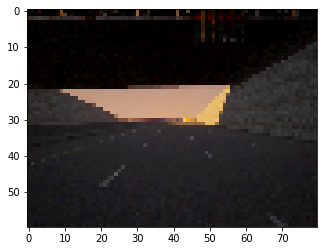

In [8]:
show_image(X_train[0])

In [ ]:
model = ImiCarla(input_shape=input_shape)

In [ ]:
optim = optimizers.Adam(learning_rate=0.001)
model.compile(optim, loss="mean_squared_error")

In [25]:
model.fit(x=X_train, y=y_train, batch_size=16, epochs=10, verbose=2, validation_split=0.15, shuffle=True)

Epoch 1/100
108/108 - 21s - loss: 0.6175 - val_loss: 1.3306
Epoch 2/100
108/108 - 21s - loss: 0.2372 - val_loss: 0.0304
Epoch 3/100


KeyboardInterrupt: 